In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


폰트 설치

In [2]:
!apt-get install fonts-nanum -y
!pip install streamlit pyngrok

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (7,214 kB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 121689 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 142.9 MB/s eta 0:00:00


In [3]:
!apt-get install -qq fonts-nanum

In [4]:
import os
import matplotlib

# 폰트 캐시 디렉토리 삭제
font_cache = matplotlib.get_cachedir()
print("Font cache:", font_cache)

!rm -rf ~/.cache/matplotlib/*

Font cache: /root/.cache/matplotlib


런타임 재시작 후 아래 코드부터 실행

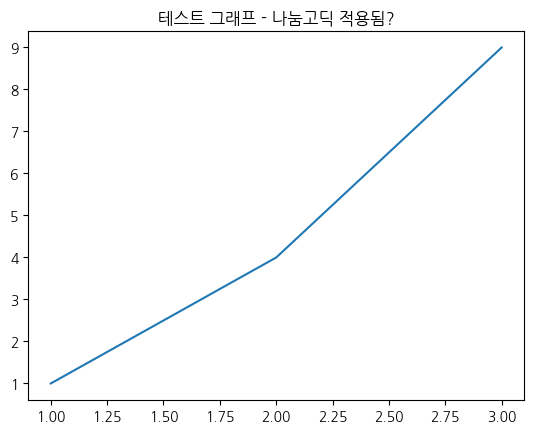

In [1]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'NanumGothic'

plt.plot([1,2,3],[1,4,9])
plt.title("테스트 그래프 - 나눔고딕 적용됨?")
plt.show()

Streamlit 및 ngrok 설치

In [2]:
!pip install streamlit

In [3]:
!pip install pyngrok

app_streamlit.py 파일 생성

In [4]:
import os
os.environ["OPENAI_API_KEY"] = "sk-YOUR API KEY"

In [5]:
# app_streamlit.py
# -*- coding: utf-8 -*-
%%writefile app_streamlit.py
import os
import pandas as pd
import numpy as np
import streamlit as st
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

from openai import OpenAI  # LLM용

# ---------------------------------------------------------
# 0. 폰트 설정
# ---------------------------------------------------------
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
if os.path.exists(font_path):
    fm.fontManager.addfont(font_path)
    mpl.rc("font", family="NanumGothic")

mpl.rcParams["axes.unicode_minus"] = False


# ---------------------------------------------------------
# 1. OpenAI 클라이언트 & LLM 유틸
# ---------------------------------------------------------
def clean_top_keywords(text):
    """
    top_keywords 컬럼에서 의미 없는 불용어(동사, 조사 등)를 제거하고,
    상위 키워드만 깔끔하게 보여주기 위한 전처리 함수.
    """
    if not isinstance(text, str):
        return text

    # 분리: "로봇(33), 있다(17) ..." 형태 → ["로봇(33)", "있다(17)", ...]
    parts = [t.strip() for t in text.split(",")]

    cleaned = []
    stopwords = {"있다", "했다", "통해", "밝혔다", "위해", "이번", "지난",
                 "대한", "관련", "하고", "하며", "중", "등", "더", "수", "것",
                 "있다고", "말했다", "다른기사", "재배포", "저작권자", "무단전재",
                 "금지", "있는", "박상일", "김진오", "로봇신문", "보기", "장길수",
                 "irobotnews", "com", "ksjang", "것으로", "등을", "따르면",
                 "선보인다", "조규남", "로봇과", "로봇의", "예정이다", "따라",
                 "있어", "보다", "위한", "지난해", "회사는", "같은", "것은", "것으로"}

    for p in parts:
        # "(숫자)" 제거
        word = p.split("(")[0].strip()

        # 불용어 제거
        if word in stopwords:
            continue

        # 한 글자 (조사 등) 제거
        if len(word) <= 1:
            continue

        cleaned.append(word)

    # 순수 키워드만 쉼표로 다시 연결
    return ", ".join(cleaned)


def get_openai_client():
    """
    OPENAI_API_KEY 환경변수를 보고 클라이언트를 만든다.
    키가 없으면 None과 에러 메시지를 반환해서 스트림릿이 죽지 않도록 함.
    """
    api_key = os.getenv("OPENAI_API_KEY")
    if not api_key:
        msg = (
            "OPENAI_API_KEY 환경변수가 설정되어 있지 않습니다.\n\n"
            "Colab 코드 셀에서 아래처럼 먼저 실행해 주세요.\n\n"
            "```python\n"
            "import os\n"
            "os.environ['OPENAI_API_KEY'] = 'API_키_입력'\n"
            "```\n"
        )
        return None, msg
    try:
        client = OpenAI(api_key=api_key)
        return client, None
    except Exception as e:
        return None, f"OpenAI 클라이언트 생성 중 오류가 발생했습니다: {e}"


def _build_discourse_context(disc_slice: pd.DataFrame, country: str):
    """
    LLM에게 넘길 데이터 요약 문자열을 만드는 헬퍼.
    너무 길어지지 않도록 상위 몇 개만 사용.
    """
    if disc_slice.empty:
        return "선택된 기간/필터에 해당하는 담론 데이터가 없습니다."

    # 토픽별 전체 doc_count
    by_label = (
        disc_slice.groupby("label")["doc_count"]
        .sum()
        .reset_index()
        .sort_values("doc_count", ascending=False)
    )

    # 월별 × 토픽별 (상위 몇 개만)
    by_month_label = (
        disc_slice.groupby(["year_month", "label"])["doc_count"]
        .sum()
        .reset_index()
        .sort_values(["year_month", "doc_count"], ascending=[True, False])
    )

    # 길이 제한을 위해 앞쪽 일부만 사용
    by_label_head = by_label.head(15)
    by_month_label_head = by_month_label.head(40)

    lines = []
    lines.append(f"- 선택된 데이터 국가(열 기준): {', '.join(sorted(disc_slice['country'].unique()))}")
    lines.append(
        f"- 샘플 수(담론 그룹 수 기준): {len(disc_slice)}"
    )
    lines.append("\n[토픽별 전체 기사 수 상위 15개]")
    for _, row in by_label_head.iterrows():
        lines.append(f"  - 토픽 '{row['label']}': 기사 수 {int(row['doc_count'])}건")

    lines.append("\n[월별 × 토픽별 기사 수 (일부)]")
    for _, row in by_month_label_head.iterrows():
        ym = row["year_month"]
        label = row["label"]
        cnt = int(row["doc_count"])
        lines.append(f"  - {ym} / '{label}': {cnt}건")

    return "\n".join(lines)


def run_llm_query(question, disc, start_month, end_month, country, label_filter):
    """
    1번 기능: 현재 필터/기간에 해당하는 담론 데이터 요약을 기반으로,
    사용자가 입력한 질문에 대해 LLM이 분석 답변을 생성.
    """
    client, err = get_openai_client()
    if err:
        return err

    # 필터와 동일한 기준으로 데이터 슬라이스
    disc_slice = disc.copy()
    disc_slice = disc_slice[
        (disc_slice["year_month"].astype(str) >= start_month)
        & (disc_slice["year_month"].astype(str) <= end_month)
    ]
    if label_filter != "전체":
        disc_slice = disc_slice[disc_slice["label"] == label_filter]

    context_text = _build_discourse_context(disc_slice, country)

    prompt = f"""
당신은 로봇/AI 산업 관련 뉴스를 분석하는 데이터 분석가입니다.
아래는 사용자가 선택한 기간과 필터에 해당하는 뉴스 토픽 집계 요약입니다.

[데이터 요약]
{context_text}

[사용자 질문]
{question}

요구사항:
1. 위 '데이터 요약'에 근거해서만 답변하세요.
2. 데이터에 없는 내용은 "데이터 상에서는 확인되지 않는다"라고 명시해 주세요.
3. 한국어로 4~7문장 정도의 자연스러운 분석 문단을 작성해 주세요.
4. 가능하다면, 증가/감소 추세나 한국 vs 일본의 차이를 언급해 주세요.
"""

    try:
        completion = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {
                    "role": "system",
                    "content": "당신은 한국어로 답변하는 로봇/AI 뉴스 데이터 분석가입니다.",
                },
                {"role": "user", "content": prompt},
            ],
        )
        return completion.choices[0].message.content.strip()
    except Exception as e:
        return f"LLM 호출 중 오류가 발생했습니다: {e}"


def generate_auto_report(
    country,
    label_filter,
    start_month,
    end_month,
    disc_filtered: pd.DataFrame,
    comp_pivot: pd.DataFrame,
):
    """
    3번 기능: 현재 필터 기준의 자동 요약 보고서를 LLM으로 생성.
    """
    client, err = get_openai_client()
    if err:
        return err

    # 현재 필터링된 담론 데이터를 그대로 사용
    if disc_filtered.empty:
        base_summary = "선택된 기간과 필터에 해당하는 담론 데이터가 없습니다."
    else:
        base_summary = _build_discourse_context(disc_filtered, country)

    # 국가 레벨 토픽 비교(comp_pivot)를 간단히 텍스트로 변환
    comp_lines = []
    comp_lines.append("[국가별 토픽 전체 기사 수 요약]")
    for label in comp_pivot.index:
        row = comp_pivot.loc[label]
        j = int(row.get("Japan", 0))
        k = int(row.get("Korea", 0))
        comp_lines.append(f"  - 토픽 '{label}': 일본 {j}건, 한국 {k}건")
    comp_text = "\n".join(comp_lines[:40])

    prompt = f"""
당신은 로봇/AI 산업 관련 뉴스를 분석하여 보고서를 작성하는 데이터 분석가입니다.

[분석 조건]
- 기간: {start_month} ~ {end_month}
- 대시보드 국가 선택: {country}
- 토픽 라벨 필터: {label_filter}

[담론 데이터 요약]
{base_summary}

[국가별 토픽 비교 요약]
{comp_text}

위 정보를 바탕으로 다음 형식을 갖춘 한국어 분석 보고서를 작성해 주세요.

1. 분석 개요
   - 데이터 기간, 국가, 토픽 범위를 자연스럽게 소개

2. 주요 토픽 동향
   - 기사 수가 많은 토픽, 빠르게 증가/감소하는 토픽이 있다면 서술
   - 시기별 특징적인 이벤트가 보이면 언급

3. 국가별 비교 (Korea vs Japan)
   - 어떤 토픽에서 어느 나라가 더 활발한지, 전반적인 차이 요약

4. 시사점 및 앞으로의 관찰 포인트
   - 산업/정책/시장 관점에서 어떤 의미가 있을지 3~5문장 정도로 제안

조건:
- 전체 분량은 10~20 문장 정도의 자연스러운 서술형 문단으로 작성
- 표 또는 숫자 나열보다는, 정리된 서술 위주로 작성
- 근거가 불충분한 내용은 '추측'이라고 명시하거나, 아예 언급하지 말 것
"""

    try:
        completion = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {
                    "role": "system",
                    "content": "당신은 로봇/AI 산업 뉴스를 분석하는 한국어 데이터 분석가입니다.",
                },
                {"role": "user", "content": prompt},
            ],
        )
        return completion.choices[0].message.content.strip()
    except Exception as e:
        return f"자동 보고서 생성 중 오류가 발생했습니다: {e}"


# ---------------------------------------------------------
# 2. 경로 설정
# ---------------------------------------------------------
BASE = "/content/drive/MyDrive/NLP/robot_news"

KO_DISC_FILE = os.path.join(BASE, "Ko_discourse_with_llm.csv")
JA_DISC_FILE = os.path.join(BASE, "Ja_discourse_with_llm.csv")
KO_TOPIC_FILE = os.path.join(BASE, "Ko_topics_lda.csv")
JA_TOPIC_FILE = os.path.join(BASE, "Ja_topics_lda.csv")


# ---------------------------------------------------------
# 3. 데이터 로딩 & 전처리
# ---------------------------------------------------------
@st.cache_data
def load_discourse():
    disc_ko = pd.read_csv(KO_DISC_FILE)
    disc_ja = pd.read_csv(JA_DISC_FILE)

    if "year_month_dt" not in disc_ko.columns:
        disc_ko["year_month_dt"] = pd.to_datetime(
            disc_ko["year_month"], format="%Y-%m", errors="coerce"
        )
    else:
        disc_ko["year_month_dt"] = pd.to_datetime(
            disc_ko["year_month_dt"], errors="coerce"
        )

    if "year_month_dt" not in disc_ja.columns:
        disc_ja["year_month_dt"] = pd.to_datetime(
            disc_ja["year_month"], format="%Y-%m", errors="coerce"
        )
    else:
        disc_ja["year_month_dt"] = pd.to_datetime(
            disc_ja["year_month_dt"], errors="coerce"
        )

    disc_ko["top_keywords"] = disc_ko["top_keywords"].apply(clean_top_keywords)
    disc_ja["top_keywords"] = disc_ja["top_keywords"].apply(clean_top_keywords)

    return disc_ko, disc_ja


def build_label_trend(disc):
    # 연월 기반 pivot: index = year_month, columns = label, values = doc_count
    df = disc.copy()
    df = df.groupby(["year_month", "label"])["doc_count"].sum().reset_index()

    pivot = df.pivot(index="year_month", columns="label", values="doc_count").fillna(0)

    pivot.index = pd.to_datetime(pivot.index, format="%Y-%m", errors="coerce")
    pivot = pivot.sort_index()

    return pivot


def compute_topic_trend_from_topics_csv(path, country_name):
    df = pd.read_csv(path)

    # published_at_iso 기준으로 year_month 생성
    dt = pd.to_datetime(df["published_at_iso"], errors="coerce")
    df["year_month"] = dt.dt.to_period("M").astype(str)

    topic_cols = [c for c in df.columns if c.startswith("topic_")]
    df["top_topic"] = df[topic_cols].values.argmax(axis=1)

    trend = (
        df.groupby(["year_month", "top_topic"])
        .size()
        .reset_index(name="count")
    )

    pivot = trend.pivot(
        index="year_month", columns="top_topic", values="count"
    ).fillna(0)

    pivot.index = pd.to_datetime(pivot.index, format="%Y-%m", errors="coerce")
    pivot = pivot.sort_index()
    pivot.attrs["country"] = country_name
    return pivot


@st.cache_data
def load_all():
    disc_ko, disc_ja = load_discourse()

    trend_ko = compute_topic_trend_from_topics_csv(KO_TOPIC_FILE, "Korea")
    trend_ja = compute_topic_trend_from_topics_csv(JA_TOPIC_FILE, "Japan")

    # 국가 비교용 집계
    cols = ["country", "label", "doc_count", "year_month_dt"]
    all_disc = pd.concat([disc_ko[cols], disc_ja[cols]], ignore_index=True)

    grouped = all_disc.groupby(["label", "country"])
    records = []
    for (label, country), g in grouped:
        total_docs = g["doc_count"].sum()
        first_month = g["year_month_dt"].min()
        last_month = g["year_month_dt"].max()
        records.append(
            {
                "label": label,
                "country": country,
                "total_docs": int(total_docs),
                "first_month": first_month,
                "last_month": last_month,
            }
        )
    comp_df = pd.DataFrame(records)
    comp_pivot = (
        comp_df.pivot(index="label", columns="country", values="total_docs")
        .fillna(0)
        .astype(int)
    )

    return disc_ko, disc_ja, trend_ko, trend_ja, comp_df, comp_pivot


disc_ko, disc_ja, trend_ko, trend_ja, comp_df, comp_pivot = load_all()
label_trend_ko = build_label_trend(disc_ko)
label_trend_ja = build_label_trend(disc_ja)

# ---------------------------------------------------------
# 4. Streamlit 레이아웃 설정
# ---------------------------------------------------------
st.set_page_config(
    page_title="Robot News Discourse Dashboard",
    layout="wide",
)

st.title("🤖 Robot News Discourse Dashboard")
st.markdown(
    "한국/일본 로봇 관련 뉴스 데이터에 대한 **토픽·시계열·담론·국가별 비교** 대시보드입니다."
)


# ---------------------------------------------------------
# 5. Sidebar 필터 + LLM 질의 입력
# ---------------------------------------------------------
st.sidebar.header("필터")

country = st.sidebar.selectbox(
    "국가 선택",
    ["Korea", "Japan", "Both"],
    index=0,
)

if country == "Korea":
    disc = disc_ko
    trend = trend_ko
elif country == "Japan":
    disc = disc_ja
    trend = trend_ja
else:
    # Both: disc만 합쳐서 사용, trend는 아래에서 개별 탭에서 사용
    disc = pd.concat([disc_ko, disc_ja], ignore_index=True)
    trend = None

# 토픽 라벨 목록
topic_labels = sorted(disc["label"].dropna().unique().tolist())
label_filter = st.sidebar.selectbox(
    "토픽 라벨 선택",
    ["전체"] + topic_labels,
)

# ---- LLM 질의 입력 ----
st.sidebar.subheader("🤖 LLM 질의응답")
user_question = st.sidebar.text_area(
    "분석 질문을 입력하세요",
    placeholder="예: 2024~2025 한국 로봇 뉴스에서 증가한 토픽을 설명해줘",
)


# ---------------------------------------------------------
# 6. 연-월 슬라이더
# ---------------------------------------------------------
month_series = (
    disc["year_month_dt"]
    .dropna()
    .dt.to_period("M")
    .astype(str)
)

month_series = month_series[month_series.str.len() == 7]
month_series = month_series[month_series <= "2025-08"]

all_months = sorted(month_series.unique().tolist())

if len(all_months) >= 2:
    start_month, end_month = st.sidebar.select_slider(
        "기간 선택 (year-month)",
        options=all_months,
        value=(all_months[0], all_months[-1]),
    )
else:
    start_month = end_month = all_months[0]


# ---------------------------------------------------------
# 7. 상단 요약 카드
# ---------------------------------------------------------
col_a, col_b, col_c = st.columns(3)
with col_a:
    st.metric("전체 담론 그룹 수", len(disc))
with col_b:
    st.metric("서로 다른 토픽 라벨 수", disc["label"].nunique())
with col_c:
    st.metric("분석 기간(월)", len(all_months))


# ---------------------------------------------------------
# 8. 시계열 토픽 트렌드
# ---------------------------------------------------------
st.subheader("📈 Topic Trend over Time")

if country in ["Korea", "Japan"]:
    trend_local = label_trend_ko if country == "Korea" else label_trend_ja

    trend_local = trend_local[
        (trend_local.index >= pd.to_datetime(start_month)) &
        (trend_local.index <= pd.to_datetime(end_month))
    ]

    fig, ax = plt.subplots(figsize=(10, 4))
    trend_local.plot(ax=ax)
    ax.set_title(f"Topic Document Count Trend ({country})")
    ax.set_xlabel("Date (Year-Month)")
    ax.set_ylabel("Document Count")
    ax.legend(title="Topic Label", bbox_to_anchor=(1.05, 1), loc="upper left")
    st.pyplot(fig)

else:
    tab_ko, tab_ja = st.tabs(["Korea", "Japan"])
    with tab_ko:
        trend_local = label_trend_ko[
            (label_trend_ko.index >= pd.to_datetime(start_month)) &
            (label_trend_ko.index <= pd.to_datetime(end_month))
        ]

        fig, ax = plt.subplots(figsize=(10, 4))
        trend_local.plot(ax=ax)
        ax.set_title("Topic Document Count Trend (Korea)")
        ax.set_xlabel("Date")
        ax.set_ylabel("Document Count")
        ax.legend(title="Topic Label", bbox_to_anchor=(1.05, 1), loc="upper left")
        st.pyplot(fig)


    with tab_ja:
        trend_local = label_trend_ja[
            (label_trend_ja.index >= pd.to_datetime(start_month)) &
            (label_trend_ja.index <= pd.to_datetime(end_month))
        ]

        fig, ax = plt.subplots(figsize=(10, 4))
        trend_local.plot(ax=ax)
        ax.set_title("Topic Document Count Trend (Japan)")
        ax.set_xlabel("Date")
        ax.set_ylabel("Document Count")
        ax.legend(title="Topic Label", bbox_to_anchor=(1.05, 1), loc="upper left")
        st.pyplot(fig)


# ---------------------------------------------------------
# 9. 담론 테이블
# ---------------------------------------------------------
st.subheader("🤖 Discourse Table (Topic × Time)")

disc_filtered = disc.copy()
disc_filtered = disc_filtered[
    (disc_filtered["year_month"].astype(str) >= start_month)
    & (disc_filtered["year_month"].astype(str) <= end_month)
]

if label_filter != "전체":
    disc_filtered = disc_filtered[disc_filtered["label"] == label_filter]

st.dataframe(
    disc_filtered[[
        "country", "year_month",
        "label", "doc_count", "top_keywords"
    ]].sort_values(["country", "year_month", "label"]),
    use_container_width=True
)

# ---------------------------------------------------------
# 10. 특정 (연-월, 토픽)의 상세 담론 보기
# ---------------------------------------------------------
st.subheader("🔍 선택한 (연-월, 토픽)의 상세 담론")

if not disc_filtered.empty:
    col1, col2 = st.columns(2)
    with col1:
        ym_selected = st.selectbox(
            "연-월 선택",
            sorted(disc_filtered["year_month"].unique()),
        )

    with col2:
        labels_for_ym = sorted(
            disc_filtered[disc_filtered["year_month"] == ym_selected]["label"].unique()
        )

        label_selected = st.selectbox(
            "토픽 선택",
            labels_for_ym
        )


    detail = disc_filtered[
        (disc_filtered["year_month"] == ym_selected)
        & (disc_filtered["label"] == label_selected)
    ]

    if not detail.empty:
        row = detail.iloc[0]
        st.markdown(f"**국가:** {row['country']}")
        st.markdown(f"**토픽 라벨:** {row['label']}")
        st.markdown(f"**기사 수:** {row['doc_count']}")
        st.markdown(f"**상위 키워드:** {row['top_keywords']}")

        st.markdown("**샘플 문장(기사 일부)**")
        for i, sent in enumerate((row["sample_sentences"] or "").split(" || "), 1):
            if sent.strip():
                st.markdown(f"> ({i}) {sent.strip()}")

        if "llm_summary" in row and isinstance(row["llm_summary"], str):
            st.markdown("**🤖 LLM 담론 요약**")
            st.write(row["llm_summary"])
        else:
            st.info("이 그룹에 대한 LLM 요약이 아직 없습니다.")
else:
    st.info("선택된 필터에 해당하는 담론 데이터가 없습니다.")


# ---------------------------------------------------------
# 11. 국가별 토픽 비교
# ---------------------------------------------------------
st.subheader("🌍 Country-level Topic Comparison")

st.markdown("토픽 라벨 기준으로 국가별 총 기사 수 비교:")

pivot_safe = comp_pivot.copy()
pivot_safe.index = (
    pivot_safe.index.astype(str)
    .str.replace("\ufeff", "", regex=False)
    .str.strip()
)

st.dataframe(pivot_safe)

fig2, ax2 = plt.subplots(figsize=(8, 4))
pivot_safe.plot(kind="bar", ax=ax2)

ax2.set_title("Total Document Count by Topic Label × Country", fontsize=12)
ax2.set_xlabel("Topic Label", fontsize=10)
ax2.set_ylabel("Total Document Count", fontsize=10)
ax2.legend(title="Country")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
st.pyplot(fig2)


# ---------------------------------------------------------
# 12. LLM 기능 결과 표시
# ---------------------------------------------------------

# 12-1) 사이드바 버튼 동작 정의
if st.sidebar.button("질문 분석하기"):
    if user_question.strip():
        with st.spinner("LLM이 분석 중입니다..."):
            answer = run_llm_query(
                question=user_question,
                disc=disc,
                start_month=start_month,
                end_month=end_month,
                country=country,
                label_filter=label_filter,
            )
        st.session_state["llm_answer"] = answer
    else:
        st.session_state["llm_answer"] = "먼저 질문을 입력해 주세요."

st.subheader("📄 자동 보고서 생성")
if st.button("현재 필터 기준으로 자동 분석 보고서 생성"):
    with st.spinner("LLM이 보고서를 생성 중입니다..."):
        report = generate_auto_report(
            country=country,
            label_filter=label_filter,
            start_month=start_month,
            end_month=end_month,
            disc_filtered=disc_filtered,
            comp_pivot=pivot_safe,
        )
    st.session_state["auto_report"] = report

# 12-2) 질의응답/보고서 출력
if "llm_answer" in st.session_state:
    st.markdown("## 🤖 LLM 질의응답 결과")
    st.write(st.session_state["llm_answer"])

if "auto_report" in st.session_state:
    st.markdown("## 📊 자동 분석 보고서")
    st.write(st.session_state["auto_report"])


Writing app_streamlit.py


Streamlit 백그라운드 실행

In [ ]:
!pkill streamlit
!pkill -f 8501

In [ ]:
!OPENAI_API_KEY="sk-YOUR API KEY" nohup streamlit run app_streamlit.py \
    --server.port=8501 --server.address=0.0.0.0 >/dev/null 2>&1 &

In [ ]:
!ps -ef | grep streamlit

root       11060       1 49 03:18 ?        00:00:01 /usr/bin/python3 /usr/local/bin/streamlit run app_streamlit.py --server.port=8501 --server.address=0.0.0.0
root       11079    1841  0 03:18 ?        00:00:00 /bin/bash -c ps -ef | grep streamlit
root       11081   11079  0 03:18 ?        00:00:00 grep streamlit


ngrok 터널 열기

In [ ]:
from pyngrok import ngrok
ngrok.set_auth_token("YOUR ngrok TOKEN")

public_url = ngrok.connect("http://0.0.0.0:8501")
public_url


<NgrokTunnel: "https://sylvia-challengeable-adelynn.ngrok-free.dev" -> "http://0.0.0.0:8501">